In [1]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
import pandas as pd
from google.api_core.exceptions import ResourceExhausted
from sklearn.preprocessing import OneHotEncoder
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from Project.utils.storage import youtube_db as db

importlib.reload(db)

<module 'Project.utils.storage.youtube_db' from 'C:\\Users\\Filippo Corti\\Documents\\GitHub\\SocialMediaMining\\Project\\utils\\storage\\youtube_db.py'>

In [3]:
"""
THE YOUTUBE MACHINE LEARNING PIPELINE:

1. Build a DataFrame with [content, podcast_guest, bias, leaning, is_political, sentiment, emotion, llm_label].

2. Extract a sub-DataFrame with only rows that have llm_label.

3. Define Snorkel Labeling Functions

4. Run Snorkel on sub-DataFrame to create 50k labeled instances. We can check which labels were more important.

5. Manually label 150 instances in the entire DataFrame.

6. Create a DataFrame having [content, podcast_guest, bias, leaning, sentiment, emotion, SNORKEL_LABEL].

7. Build a Model using sklearn (Cross Validation and other stuff), training it on the DataFrame on point 6. Check Performance

8. Run the Model on the entire Dataset. Check Performance based on my 150 instances.

At the end, every comment has a label produced by my Classification Model

"""


'\nTHE YOUTUBE MACHINE LEARNING PIPELINE:\n\n1. Build a DataFrame with [content, podcast_guest, bias, leaning, is_political, sentiment, emotion, llm_label].\n\n2. Extract a sub-DataFrame with only rows that have llm_label.\n\n3. Define Snorkel Labeling Functions\n\n4. Run Snorkel on sub-DataFrame to create 50k labeled instances. We can check which labels were more important.\n\n5. Manually label 150 instances in the entire DataFrame.\n\n6. Create a DataFrame having [content, podcast_guest, bias, leaning, sentiment, emotion, SNORKEL_LABEL].\n\n7. Build a Model using sklearn (Cross Validation and other stuff), training it on the DataFrame on point 6. Check Performance\n\n8. Run the Model on the entire Dataset. Check Performance based on my 150 instances.\n\nAt the end, every comment has a label produced by my Classification Model\n\n'

In [2]:
trump_podcasts = [
    "xrFdHO7FH8w",
    "blqIZGXWUpU",
    "s11uIW7wi-E",
    "vC5cHjcgt5g",
    "G80iLTctFuY",
    "qCbfTN-caFI",
    "Ry1IjOft95c",
    "S7BTdUaNQM8",
    "1SsmPh8gCxU",
    "-dmwG54QsKc",
    "nwQil7tcImI",
    "G9lXnwuZ2qs",
    "hBMoPUAeLnY"
]

harris_podcasts = [
    "_KCRsjPCiCI",
    "bzThwqnQJDY",
    "7L4sts7I3xI",
    "pNbwMrBMGgE",
    "Vu5yD3fu6A8",
]

youtube_db = db.SQLiteYoutubeSaver(db_name='../db/youtube.db')

In [311]:
youtube_db.cursor.execute(f"""
SELECT Comments.id, in_reply_to_id, content, video_id, bias, leaning, is_political, sentiment, emotion, llm_label
FROM CommentAnalysis JOIN Comments on Comments.id = CommentAnalysis.id
""")

data = youtube_db.cursor.fetchall()


df = pd.DataFrame(data)
df.columns = ['id', 'in_reply_to_id', 'content', 'video_id', 'bias', 'leaning', 'is_political', 'sentiment', 'emotion', 'llm_label']
df['podcast_guest'] = ['Trump' if video_id in trump_podcasts else 'Harris' for video_id in df['video_id']]
df.drop('video_id', axis=1, inplace=True)



In [312]:
comments_map = {
    x[1]["id"]: x[1]
    for x in df.iterrows()
}

In [313]:
df

,id,in_reply_to_id,content,bias,leaning,is_political,sentiment,emotion,llm_label,podcast_guest
0,UgyfluKW3Ug3sy7JipJ4AaABAg,None,Best Podcast of All-time? 🤔🔥,RIGHT,RIGHT,0,Positive,joy,Republican,Trump
1,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWgAZknY6,UgyfluKW3Ug3sy7JipJ4AaABAg,Definitely my favorite!,RIGHT,LEFT,0,Positive,joy,Republican,Trump
2,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpEh0att,UgyfluKW3Ug3sy7JipJ4AaABAg,"No, best guest",RIGHT,RIGHT,0,Positive,joy,Republican,Trump
3,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpMKmUEI,UgyfluKW3Ug3sy7JipJ4AaABAg,Probably,RIGHT,LEFT,0,Neutral,anticipation,Republican,Trump
4,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWt4CmVAq,UgyfluKW3Ug3sy7JipJ4AaABAg,Under 30 seconds,RIGHT,RIGHT,0,Neutral,anticipation,Neutral,Trump
...,...,...,...,...,...,...,...,...,...,...
114695,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AA9xuMlvsYZ,UgyHorsmGTU9LHUXCBJ4AaABAg,How do you check the numbers from your phone ...,RIGHT,RIGHT,0,Negative,disgust,None,Harris
114696,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AA9yMqEcrPM,UgyHorsmGTU9LHUXCBJ4AaABAg,@@BruceDragon-sf1tr just google it fam. I prom...,LEFT,RIGHT,0,Neutral,optimism,None,Harris
114697,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AAA-zsorgCI,UgyHorsmGTU9LHUXCBJ4AaABAg,its now 34k to 88k now lolol,LEFT,LEFT,0,Positive,joy,None,Harris
114698,UgyHorsmGTU9LHUXCBJ4AaABAg.AA9n_pk7NK3AAA04ke2mdj,UgyHorsmGTU9LHUXCBJ4AaABAg,@@BruceDragon-sf1trjust add it to your browser...,LEFT,RIGHT,0,Neutral,anger,None,Harris


In [346]:
df_with_llm_labels = df[df["llm_label"].notna()].copy()

In [347]:
df_with_llm_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52451 entries, 0 to 93638
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              52451 non-null  object
 1   in_reply_to_id  49587 non-null  object
 2   content         52451 non-null  object
 3   bias            52451 non-null  object
 4   leaning         52451 non-null  object
 5   is_political    52451 non-null  int64 
 6   sentiment       52451 non-null  object
 7   emotion         52451 non-null  object
 8   llm_label       52451 non-null  object
 9   podcast_guest   52451 non-null  object
dtypes: int64(1), object(9)
memory usage: 4.4+ MB


In [348]:
df_with_llm_labels

,id,in_reply_to_id,content,bias,leaning,is_political,sentiment,emotion,llm_label,podcast_guest
0,UgyfluKW3Ug3sy7JipJ4AaABAg,None,Best Podcast of All-time? 🤔🔥,RIGHT,RIGHT,0,Positive,joy,Republican,Trump
1,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWgAZknY6,UgyfluKW3Ug3sy7JipJ4AaABAg,Definitely my favorite!,RIGHT,LEFT,0,Positive,joy,Republican,Trump
2,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpEh0att,UgyfluKW3Ug3sy7JipJ4AaABAg,"No, best guest",RIGHT,RIGHT,0,Positive,joy,Republican,Trump
3,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpMKmUEI,UgyfluKW3Ug3sy7JipJ4AaABAg,Probably,RIGHT,LEFT,0,Neutral,anticipation,Republican,Trump
4,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWt4CmVAq,UgyfluKW3Ug3sy7JipJ4AaABAg,Under 30 seconds,RIGHT,RIGHT,0,Neutral,anticipation,Neutral,Trump
...,...,...,...,...,...,...,...,...,...,...
93634,UgwtZ5FZ8C7dTnDZAKV4AaABAg,None,Curious why she didn’t get called out for not ...,LEFT,RIGHT,1,Negative,anger,Democratic,Harris
93635,Ugzq-N-U0VpXLVuamXN4AaABAg,None,"She already thinks she has won. ""When I was Vi...",RIGHT,RIGHT,1,Negative,anticipation,Republican,Harris
93636,Ugzq-N-U0VpXLVuamXN4AaABAg.A9eP05BLNGaA9eWjEMHm_h,Ugzq-N-U0VpXLVuamXN4AaABAg,Technically she can be the president if she us...,RIGHT,RIGHT,1,Neutral,anticipation,Republican,Harris
93637,Ugzq-N-U0VpXLVuamXN4AaABAg.A9eP05BLNGaA9eex9dkNBB,Ugzq-N-U0VpXLVuamXN4AaABAg,That's what people need to realize. If she was...,LEFT,RIGHT,1,Negative,anger,Democratic,Harris


In [349]:
# Label Space
REPUBLICAN = 0
DEMOCRATIC = 1
NEUTRAL = 2
ABSTAIN = -1

In [350]:
@labeling_function()
def lf_llm(x):
    match x.llm_label:
        case "Republican":
            return REPUBLICAN
        case "Democratic":
            return DEMOCRATIC
        case "Neutral":
            return NEUTRAL
        case _:
            return ABSTAIN


@labeling_function()
def lf_bias(x):
    if not x.is_political: return NEUTRAL
    match x.bias:
        case "LEFT":
            return DEMOCRATIC
        case "RIGHT":
            return REPUBLICAN
    return ABSTAIN


@labeling_function()
def lf_leaning(x):
    if not x.is_political: return NEUTRAL
    match x.leaning:
        case "RIGHT":
            return REPUBLICAN
        case "LEFT":
            return DEMOCRATIC
    return ABSTAIN

@labeling_function()
def lf_bias_leaning(x):
    if not x.is_political: return NEUTRAL
    match (x.bias, x.leaning):
        case ("LEFT", "LEFT"): return DEMOCRATIC
        case ("RIGHT", "RIGHT"): return REPUBLICAN
    return ABSTAIN

@labeling_function()
def lf_llm_leaning(x):
    match (x.llm_label, x.leaning):
        case ("Democratic", "LEFT"): return DEMOCRATIC
        case ("Republican", "RIGHT"): return REPUBLICAN
    return ABSTAIN

@labeling_function()
def lf_not_political(x):
    return NEUTRAL if x.is_political == 0 else ABSTAIN

@labeling_function()
def lf_negative_sentiment(x):
    match x.sentiment:
        case "Negative":
            return DEMOCRATIC if x.podcast_guest == "Trump" else REPUBLICAN
        case "Positive":
            return REPUBLICAN if x.podcast_guest == "Trump" else DEMOCRATIC
    return ABSTAIN


@labeling_function()
def lf_emotion(x):
    match x.emotion:
        case "joy" | "surprise":
            return REPUBLICAN if x.podcast_guest == "Trump" else DEMOCRATIC
        case "anger" | "disgust":
            return DEMOCRATIC if x.podcast_guest == "Trump" else REPUBLICAN
    return ABSTAIN


@labeling_function()
def lf_bias_sentiment(x):
    match (x.bias, x.sentiment):
        case ("RIGHT", "Positive"): return REPUBLICAN
        case ("LEFT", "Positive"): return DEMOCRATIC
        case ("RIGHT", "Negative"): return DEMOCRATIC
        case ("LEFT", "Negative"): return REPUBLICAN
    return ABSTAIN

@labeling_function()
def lf_content(x):
    content = x.content.casefold()
    if "magat" in content: return DEMOCRATIC
    if "maga" in content: return REPUBLICAN
    if "censor" in content: return REPUBLICAN
    if "harris 202" in content: return DEMOCRATIC # For Harris 2024 and 2025
    if "trump 202" in content: return REPUBLICAN # For Trump 2024 and 2025
    if "kamala" in content and "great" in content:  return DEMOCRATIC
    if "trump" in content and "save" in content: return REPUBLICAN
    if "current administration" in content: return REPUBLICAN
    return ABSTAIN

@labeling_function()
def lf_guest(x):
    if x.podcast_guest == "Trump": return REPUBLICAN
    if x.podcast_guest == "Harris": return DEMOCRATIC
    return ABSTAIN


In [369]:
lfs = [
    #lf_llm,
    #lf_bias,
    #lf_leaning,
    lf_bias_leaning,
    lf_llm_leaning,
    lf_not_political,
    #lf_negative_sentiment,
    lf_emotion,
    lf_bias_sentiment,
    lf_content,
    lf_guest
]

applier = PandasLFApplier(lfs)
L = applier.apply(df_with_llm_labels)

100%|██████████| 52451/52451 [00:05<00:00, 9497.68it/s] 


In [370]:
LFAnalysis(L, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_bias,0,"[0, 1, 2]",0.945454,0.945454,0.900364
lf_bias_leaning,1,"[0, 1, 2]",0.722999,0.722999,0.691388
lf_llm_leaning,2,"[0, 1]",0.427885,0.427885,0.398543
lf_not_political,3,[2],0.440220,0.440220,0.440220
lf_emotion,4,"[0, 1]",0.730815,0.730815,0.699224
lf_bias_sentiment,5,"[0, 1]",0.815027,0.815027,0.779432
lf_content,6,"[0, 1]",0.020095,0.020095,0.017540
lf_guest,7,"[0, 1]",1.000000,0.994547,0.938152


In [371]:
label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train=L, n_epochs=500, log_freq=100)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 500/500 [00:00<00:00, 886.96epoch/s]
INFO:root:Finished Training


In [372]:
snorkel_labels = label_model.predict(L)

In [373]:
df_with_llm_labels["snorkel_labels"] = snorkel_labels
print(f"Republican: {len([l for l in snorkel_labels if l == 0])}")
print(f"Democratic: {len([l for l in snorkel_labels if l == 1])}")
print(f"Neutral: {len([l for l in snorkel_labels if l == 2])}")

Republican: 14990
Democratic: 14276
Neutral: 23185


In [374]:
confidence_levels = np.max(label_model.predict_proba(L), axis=1)
df_with_llm_labels["confidence"] = confidence_levels
print(np.count_nonzero(confidence_levels))
print(np.count_nonzero(confidence_levels >= 0.9))

52451
37843


In [375]:
df_with_llm_labels

,id,in_reply_to_id,content,bias,leaning,is_political,sentiment,emotion,llm_label,podcast_guest,snorkel_labels,confidence
0,UgyfluKW3Ug3sy7JipJ4AaABAg,None,Best Podcast of All-time? 🤔🔥,RIGHT,RIGHT,0,Positive,joy,Republican,Trump,2,0.997015
1,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWgAZknY6,UgyfluKW3Ug3sy7JipJ4AaABAg,Definitely my favorite!,RIGHT,LEFT,0,Positive,joy,Republican,Trump,2,0.998858
2,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpEh0att,UgyfluKW3Ug3sy7JipJ4AaABAg,"No, best guest",RIGHT,RIGHT,0,Positive,joy,Republican,Trump,2,0.997015
3,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWpMKmUEI,UgyfluKW3Ug3sy7JipJ4AaABAg,Probably,RIGHT,LEFT,0,Neutral,anticipation,Republican,Trump,2,0.997355
4,UgyfluKW3Ug3sy7JipJ4AaABAg.A4dWYlIOxqSA4dWt4CmVAq,UgyfluKW3Ug3sy7JipJ4AaABAg,Under 30 seconds,RIGHT,RIGHT,0,Neutral,anticipation,Neutral,Trump,2,0.997355
...,...,...,...,...,...,...,...,...,...,...,...,...
93634,UgwtZ5FZ8C7dTnDZAKV4AaABAg,None,Curious why she didn’t get called out for not ...,LEFT,RIGHT,1,Negative,anger,Democratic,Harris,0,0.924992
93635,Ugzq-N-U0VpXLVuamXN4AaABAg,None,"She already thinks she has won. ""When I was Vi...",RIGHT,RIGHT,1,Negative,anticipation,Republican,Harris,0,0.957556
93636,Ugzq-N-U0VpXLVuamXN4AaABAg.A9eP05BLNGaA9eWjEMHm_h,Ugzq-N-U0VpXLVuamXN4AaABAg,Technically she can be the president if she us...,RIGHT,RIGHT,1,Neutral,anticipation,Republican,Harris,0,0.957429
93637,Ugzq-N-U0VpXLVuamXN4AaABAg.A9eP05BLNGaA9eex9dkNBB,Ugzq-N-U0VpXLVuamXN4AaABAg,That's what people need to realize. If she was...,LEFT,RIGHT,1,Negative,anger,Democratic,Harris,0,0.924992


In [441]:
labelled_data = pd.read_csv("../data/manual_label_sample.csv", sep=";")
ids = [x for x in labelled_data["id"] if x in df_with_llm_labels["id"]]

labelled_data["id"] = labelled_data["id"].astype(str)
df_filtered = df_with_llm_labels[df_with_llm_labels["confidence"] >= 0]
df_with_llm_labels["id"] = df_filtered["id"].astype(str)

common_ids = labelled_data["id"][labelled_data["id"].isin(df_with_llm_labels["id"])]

print(len(common_ids))

manual_labels = labelled_data.set_index("id").loc[common_ids, "label"].tolist()
snorkel_labels = df_with_llm_labels.set_index("id").loc[common_ids, "snorkel_labels"].tolist()
llm_labels = df_with_llm_labels.set_index("id").loc[common_ids, "llm_label"].tolist()
leaning_labels = df_with_llm_labels.set_index("id").loc[common_ids, "leaning"].tolist()

llm_labels = [{"Republican": 0, "Democratic": 1, "Neutral": 2}.get(l) for l in llm_labels]
leaning_labels = [{"RIGHT": 0, "LEFT": 1, "CENTER": 2}.get(l) for l in leaning_labels]


210


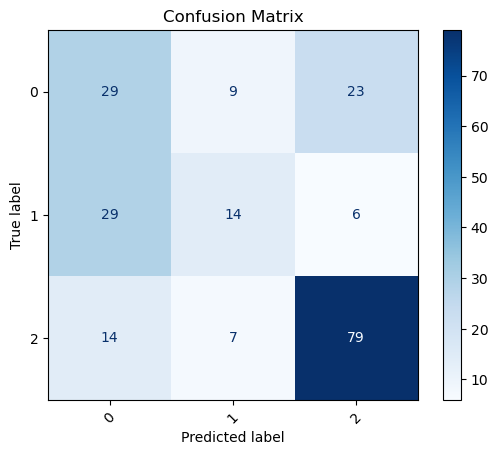

              precision    recall  f1-score   support

  Republican       0.40      0.48      0.44        61
  Democratic       0.47      0.29      0.35        49
     Neutral       0.73      0.79      0.76       100

    accuracy                           0.58       210
   macro avg       0.53      0.52      0.52       210
weighted avg       0.57      0.58      0.57       210



In [437]:
# Generate the confusion matrix
cm = confusion_matrix(manual_labels, snorkel_labels, labels=sorted(set(manual_labels + snorkel_labels)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(manual_labels + snorkel_labels)))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(manual_labels, snorkel_labels, target_names=["Republican", "Democratic", "Neutral"]))

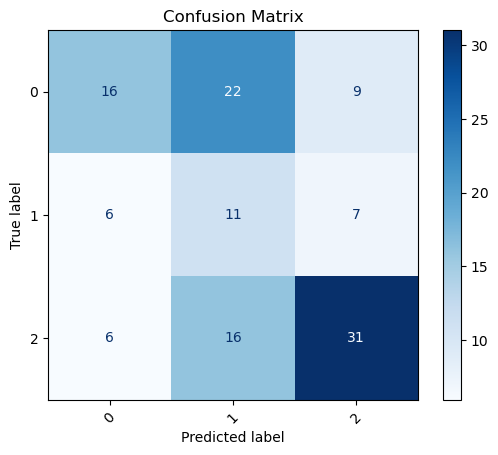

              precision    recall  f1-score   support

  Republican       0.57      0.34      0.43        47
  Democratic       0.22      0.46      0.30        24
     Neutral       0.66      0.58      0.62        53

    accuracy                           0.47       124
   macro avg       0.49      0.46      0.45       124
weighted avg       0.54      0.47      0.49       124



In [328]:
# Generate the confusion matrix
cm = confusion_matrix(manual_labels, llm_labels, labels=sorted(set(manual_labels + llm_labels)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(manual_labels + llm_labels)))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(manual_labels, llm_labels, target_names=["Republican", "Democratic", "Neutral"]))

In [464]:
import google.generativeai as genai
import json
import re
import pandas as pd

credentials = json.load(open('../../keys/google_ai_keys.json'))
api_key = credentials['api_key']

with open("../prompts/political_stance_yt.txt", "r", encoding="utf-8") as f:
    system_prompt = f.read()

genai.configure(api_key=api_key)

MODEL_NAME = "gemma-3-27b-it"

def generate_response(system_instruction: str, user_input: str) -> str:
    model_with_instruction = genai.GenerativeModel(
        model_name=MODEL_NAME,
        system_instruction=system_instruction
    )
    try:
        response = model_with_instruction.generate_content(user_input)
        return response.text.strip()
    except Exception as e:
        print(e)
        match = re.search(r"seconds:\s*(\d+)", str(e))
        retry_seconds = int(match.group(1)) if match else None
        if retry_seconds is not None:
            print(f"Quota exceeded. Retrying in {retry_seconds} seconds.")
            time.sleep(retry_seconds)

            try:
                response = model_with_instruction.generate_content(user_input)
                return response.text.strip()
            except Exception as e:
                print("Failed twice. Giving up :(")
                return None



In [465]:
ids = [x for x in labelled_data["id"]]
comments = [
    comments_map[id]
    for id in ids
]

In [ ]:
import time
gemini_labels = list()

idx = 0
while idx < len(comments):
    comment = comments[idx]
    candidate = comment["podcast_guest"]
    text = comment["content"]
    sanitized_text = text.replace('"', '\\"').replace('\n', ' ').strip()

    json_input = f'{{"candidate": "{candidate}", "comment": "{sanitized_text}"}}'
    try:
        gemini_response = generate_response(system_prompt, json_input).replace('\n', '')
        label = {"Republican": 0, "Democratic": 1, "Neutral": 2}.get(gemini_response)
        gemini_labels.append(label)
        print(f"{idx}/{len(comments)}: {gemini_response}")
        idx += 1
    except Exception as e:
        print(e)

In [440]:
print(len(gemini_labels))

210


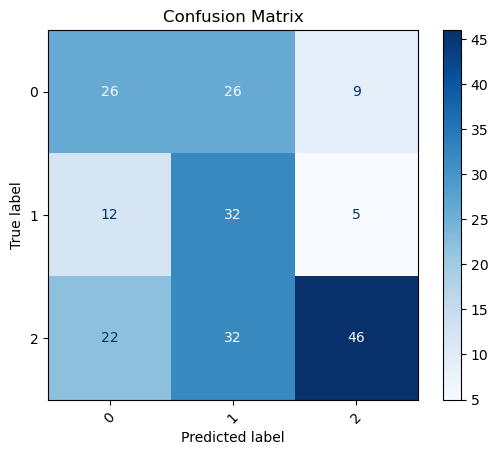

              precision    recall  f1-score   support

  Republican       0.90      0.62      0.74        61
  Democratic       0.88      0.71      0.79        49
     Neutral       0.74      0.95      0.83       100

    accuracy                           0.80       210
   macro avg       0.84      0.76      0.79       210
weighted avg       0.82      0.80      0.79       210



In [446]:
manual_labels = labelled_data.set_index("id").loc[ids, "label"].tolist()

# Generate the confusion matrix
cm = confusion_matrix(manual_labels, llm_labels, labels=sorted(set(manual_labels + gemini_labels)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(manual_labels + gemini_labels)))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(manual_labels, gemini_labels, target_names=["Republican", "Democratic", "Neutral"]))

In [447]:
labelled_data["content"] = [comments_map[id]["content"] for id in labelled_data["id"]]
labelled_data["gemini_label"] = gemini_labels
labelled_data = labelled_data[["id", "content", "label", "gemini_label"]]

In [448]:
labelled_data[labelled_data["label"] != labelled_data["gemini_label"]]

,id,content,label,gemini_label
9,UgzplbMm1dr_xCDBXI14AaABAg.A7wXVa4fHtkA7xboegmVx0,"And it makes sense, not like ""being unburdened...",2,0
10,UgyZeQtiQY2K7YeWwkV4AaABAg.A9J5E4s8NqeA9LkehBqQll,​@@RJForest.Federal employees were required to...,0,2
12,UgzwCM6M36d-8aE62Yd4AaABAg.AAgH3xz97ydAAtoScc3JVp,@@AfternoonFocus Its important to the whole wo...,1,0
24,Ugy84X_leqFyz9oBuKV4AaABAg.A9JgYEE2qoOA9KISI2mPma,"The full podcast is 45 minutes, so…….. lol",0,2
25,UgybKuLt27mgQLL4D_x4AaABAg,"This is hilariously tonedeaf, I honestly love it",0,2
28,UgwQMmexm1xNGLb6-Nd4AaABAg.A9IfhOcRU7FA9Nx0qhSr83,@@JD365-ls5cw i’ve been fuck the draft and fuc...,0,2
55,UgyZeQtiQY2K7YeWwkV4AaABAg.A9J5E4s8NqeA9KvI7cFzvQ,"@@AntoineLavoisier-y3e It's not a fact, not ev...",1,2
67,Ugwlccism2KrwKHDR7l4AaABAg.A6nm1Uqz85eA6o1VtxVcVP,Found the interview on TT… came looking for fu...,0,2
70,UgwkaAcpUhAUuF5yPJp4AaABAg.A7xgYpP5NM-A7y6t1g8lBQ,​@@b-teccan you link me to a 1 hour unedited i...,0,2
72,UgyNOdH_QhTlHoFrwcl4AaABAg.A91HMGyGV1gA92WumuGMP1,@@actin80 Kumswala ain’t winning nothing. You ...,0,2


In [435]:
labelled_data["content"] = labelled_data["content"].apply(lambda x: re.sub("\n", "", x))
labelled_data.to_csv("../data/manual_label_sample.csv", sep=";")

In [444]:
manual_labels

[]

In [463]:

list(genai.list_models())

[Model(name='models/embedding-gecko-001',
       base_model_id='',
       version='001',
       display_name='Embedding Gecko',
       description='Obtain a distributed representation of a text.',
       input_token_limit=1024,
       output_token_limit=1,
       supported_generation_methods=['embedText', 'countTextTokens'],
       temperature=None,
       max_temperature=None,
       top_p=None,
       top_k=None),
 Model(name='models/gemini-1.0-pro-vision-latest',
       base_model_id='',
       version='001',
       display_name='Gemini 1.0 Pro Vision',
       description=('The original Gemini 1.0 Pro Vision model version which was optimized for '
                    'image understanding. Gemini 1.0 Pro Vision was deprecated on July 12, 2024. '
                    'Move to a newer Gemini version.'),
       input_token_limit=12288,
       output_token_limit=4096,
       supported_generation_methods=['generateContent', 'countTokens'],
       temperature=0.4,
       max_temperature=Non

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Step 1: Load your labeled dataset
# Assume you already have a DataFrame with 'content' and 'label' columns
# Labels should be 0 (REP), 1 (DEM), 2 (NEUTRAL)
df2 = pd.read_csv("../data/manual_label_sample.csv", sep=";")

df2["content"] = [comments_map[id][2] for id in df2["id"]]

# Step 3: Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    df2["content"], df2["label"], test_size=0.2, stratify=df2["label"], random_state=42
)

# Step 4: Build classifier pipeline
clf = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
)

# Step 5: Train and evaluate
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)




print(classification_report(y_test, y_pred, target_names=["Republican", "Democratic", "Neutral"]))

In [3]:
import pandas as pd
import numpy as np
import itertools
import spacy
import re

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.decomposition import TruncatedSVD

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

#warnings.filterwarnings('ignore')
nlp = spacy.load("en_core_web_sm")

In [15]:
youtube_db.cursor.execute(f"""
SELECT Comments.id, video_id, content, gemini_label
FROM CommentAnalysis JOIN Comments on Comments.id = CommentAnalysis.id
WHERE gemini_label IS NOT NULL
""")

data = youtube_db.cursor.fetchall()

df = pd.DataFrame(data)
df.columns = ['id', 'video_id', 'content', 'label']
df["label"] = [{"Republican": 0, "Democratic": 1, "Neutral": 2}.get(label) for label in df["label"]]
df["podcast_guest"] = ["Trump" if video_id in trump_podcasts else "Harris" for video_id in df["video_id"]]

#df = df.head(1000)

X = df[["content", "podcast_guest"]]
y = df["label"]

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=30, shuffle=True
)

In [17]:
vectorizer_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=500,
        min_df=2,
        max_df=0.95,
        ngram_range=(1,1),
        stop_words='english'
    )),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer_pipeline, "content"),
        ("guest", OneHotEncoder(drop='first'), ["podcast_guest"])
    ]
)

model_pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', None),
    ('classifier', LogisticRegression())
])

In [18]:
f1_weighted_scorer = make_scorer(f1_score, average='weighted')

sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler': [SMOTE()],
        'sampler__sampling_strategy': ['auto', 'minority', 'not majority',
        ]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [TruncatedSVD()],
        'dim_reduction__n_components': [50, 80]
    },
    {
        'dim_reduction': [LDA()]
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [100, 200] , #
        'classifier__class_weight' : [None, 'balanced']
    },
    {
        'classifier': [LogisticRegression(max_iter=200, solver='liblinear')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    }
]

all_configs = [
    dict(itertools.chain(*(e.items() for e in configuration)))
    for configuration in itertools.product(
        sampler_configs,
        dim_reduction_configs,
        classifier_configs
    )
]


In [19]:
print(f"Total parameter combinations: {len(all_configs)}")

Total parameter combinations: 24


In [ ]:
rs = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=1,
    cv=2,
    scoring=f1_weighted_scorer,
    error_score='raise'
)

scores = cross_validate(rs, X_train, y_train, scoring=f1_weighted_scorer, cv=2, return_estimator=True, verbose=3)

In [13]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
LogisticRegression(C=np.float64(1.5250031941004971), class_weight='balanced',
                   max_iter=200, penalty='l1', solver='liblinear') {'C': np.float64(1.5250031941004971), 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 200, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.6891264369868967
----------
None
None
RandomForestClassifier(n_estimators=10) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.7012404090666499
----------


In [14]:
for estimator in scores['estimator']:
    estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    print("TRAINING SET: ")
    print(classification_report(y_train, pred_train, target_names=["Republican", "Democratic", "Neutral"]))
    print("\n\nTEST SET:")
    print(classification_report(y_test, pred_test, target_names=["Republican", "Democratic", "Neutral"]))

TRAINING SET: 
              precision    recall  f1-score   support

  Republican       0.78      0.64      0.70       180
  Democratic       0.80      0.79      0.80        62
     Neutral       0.87      0.93      0.90       558

    accuracy                           0.85       800
   macro avg       0.82      0.79      0.80       800
weighted avg       0.85      0.85      0.85       800



TEST SET:
              precision    recall  f1-score   support

  Republican       0.56      0.51      0.53        45
  Democratic       0.00      0.00      0.00        15
     Neutral       0.82      0.89      0.85       140

    accuracy                           0.74       200
   macro avg       0.46      0.47      0.46       200
weighted avg       0.70      0.74      0.72       200

TRAINING SET: 
              precision    recall  f1-score   support

  Republican       0.95      0.87      0.91       180
  Democratic       0.96      0.89      0.92        62
     Neutral       0.95      0.98

In [ ]:

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier",  LogisticRegression(max_iter=500, class_weight=None, random_state=42, C=1.0))
])

# Step 5: Train and evaluate
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=sorted(set(y_test).union(set(y_pred))))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(y_test).union(set(y_pred))))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=["Republican", "Democratic", "Neutral"]))